In [1]:
import os
import numpy as np
import pandas as pd
from scipy import stats
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler


import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline
plt.style.use('seaborn-v0_8-white')

In [3]:
get_local_data_path = lambda folders, fname: os.path.normpath('../local_data/' + '/'.join(folders) + '/' + fname)

In [11]:
file_decoder100_model = get_local_data_path(['models'], 'decoder_onehidden_vae100_cptac.hdf5')
file_decoder1000_model = get_local_data_path(['models'], 'decoder_onehidden_vae1000_cptac.hdf5')
file_decoder500_model = get_local_data_path(['models'], 'decoder_onehidden_vae500_cptac.hdf5')
file_tcga_transcriptomics = get_local_data_path(['processed_data'], 'CPTAC_TCGA_transcriptomics_VAE_input.parquet')

In [5]:
def get_most_variable_genes(data, n=5000):
    transcriptomics_mad = pd.DataFrame(stats.median_abs_deviation(data, axis=0), 
                                       index = data.columns, 
                                       columns= ['MAD']).dropna().sort_values(by='MAD', ascending=False)
    top_mad_genes = transcriptomics_mad.head(n).index
    return(data.reindex(top_mad_genes, axis=1))    

def apply_normalization(data):
    rnaseq_scaled_zeroone_df = MinMaxScaler().fit_transform(data)
    return(pd.DataFrame(rnaseq_scaled_zeroone_df,
                        columns=data.columns,
                        index=data.index))

def run_processing_pipeline(file):
    data = pd.read_parquet(file).drop(columns=['Study', 'Project'])
    return(apply_normalization(get_most_variable_genes(data)))

In [6]:
rnaseq_scaled_zeroone_df = run_processing_pipeline(file_tcga_transcriptomics)
rnaseq_scaled_zeroone_df[:2]

,CEACAM6,TMPRSS4,CEACAM5,SERPINB5,SLC34A2,AGR2,PIGR,FOXA1,CXCL17,ALDH3B2,...,LDHB,ELL2,SLC1A4,RAB30,CTAGE6,ENO3,CNKSR1,HERC5,C5orf34,TSGA10
X05BR044,0.556158,0.268880,0.426972,0.471907,0.427291,0.340349,0.418665,0.870931,0.599509,0.523747,...,0.389687,0.599384,0.547150,0.539518,0.552344,0.296882,0.762243,0.398071,0.497599,0.529024
X06BR006,0.548890,0.370768,0.432470,0.430804,0.478019,0.305251,0.476576,0.738325,0.613836,0.402149,...,0.505430,0.586446,0.457733,0.616628,0.512752,0.322771,0.697101,0.545798,0.540439,0.639007


In [12]:
decoder100 = load_model(file_decoder100_model)
decoder1000 = load_model(file_decoder1000_model)
decoder500 = load_model(file_decoder500_model)

In [13]:
weights100 = []
for layer in decoder100.layers:
    weights100.append(layer.get_weights())
    
weight100_layer_df = pd.DataFrame(weights100[1][0], columns=rnaseq_scaled_zeroone_df.columns, index=range(1, 101))
weight100_layer_df.head(2)

,CEACAM6,TMPRSS4,CEACAM5,SERPINB5,SLC34A2,AGR2,PIGR,FOXA1,CXCL17,ALDH3B2,...,LDHB,ELL2,SLC1A4,RAB30,CTAGE6,ENO3,CNKSR1,HERC5,C5orf34,TSGA10
1,-0.005901,-0.004604,0.002848,0.011398,-0.009268,-0.001919,0.000360,0.006497,-0.007274,-0.013542,...,0.017962,-0.003475,0.002871,-0.000376,-0.015188,-0.016013,-0.008429,0.004331,0.007180,-0.020124
2,-0.006833,-0.004020,0.006510,0.000506,-0.002759,-0.006762,-0.019233,-0.011326,-0.013663,-0.008364,...,-0.001698,-0.005350,-0.005951,0.000103,-0.001282,0.007167,0.001638,-0.033505,-0.001882,-0.003121


In [14]:
weights500 = []
for layer in decoder500.layers:
    weights500.append(layer.get_weights())
    
weight500_layer_df = pd.DataFrame(weights500[1][0], index=range(1, 501), columns=rnaseq_scaled_zeroone_df.columns)
weight500_layer_df.head(2)

,CEACAM6,TMPRSS4,CEACAM5,SERPINB5,SLC34A2,AGR2,PIGR,FOXA1,CXCL17,ALDH3B2,...,LDHB,ELL2,SLC1A4,RAB30,CTAGE6,ENO3,CNKSR1,HERC5,C5orf34,TSGA10
1,0.012500,0.003858,0.013608,0.017527,-0.005192,0.005037,0.004757,0.000591,-0.003400,0.004644,...,0.005501,-0.000827,-0.005799,0.001223,-0.002350,0.000520,-0.001862,0.001331,0.002887,-0.013093
2,-0.006899,0.000053,-0.006587,-0.000051,0.017643,-0.001263,-0.004359,0.000369,0.003081,-0.001413,...,-0.008064,0.000450,-0.001025,0.003679,-0.002541,-0.003286,-0.000658,-0.005283,-0.002851,0.001041


In [15]:
weights1000 = []
for layer in decoder1000.layers:
    weights1000.append(layer.get_weights())
    
weight1000_layer_df = pd.DataFrame(weights1000[1][0], index=range(1, 1001), columns=rnaseq_scaled_zeroone_df.columns)
weight1000_layer_df.head(2)

,CEACAM6,TMPRSS4,CEACAM5,SERPINB5,SLC34A2,AGR2,PIGR,FOXA1,CXCL17,ALDH3B2,...,LDHB,ELL2,SLC1A4,RAB30,CTAGE6,ENO3,CNKSR1,HERC5,C5orf34,TSGA10
1,-0.003219,0.011988,-0.000226,-0.002864,-0.011770,-0.001483,-0.004360,0.000876,0.002881,0.005892,...,-0.000559,0.003086,0.005114,0.007192,-0.003531,0.011184,0.000686,0.001172,0.002205,0.001186
2,-0.013536,-0.002730,-0.007173,0.001538,-0.005025,0.004104,-0.002292,0.000754,-0.010027,-0.003859,...,0.005933,0.005275,0.005391,-0.000315,-0.001263,-0.002560,0.003537,-0.007806,-0.003387,0.003781


In [16]:
def draw_extracted_weights(weights_layer, encoding1, encoding2):
    sex_node_plot = weights_layer.loc[[encoding1, encoding2]].T
    encoding1_str = 'encoding ' + str(encoding1)
    encoding2_str = 'encoding ' + str(encoding2)
    sex_node_plot.columns = [encoding1_str, encoding2_str]
    
    sex_node_plot = (sex_node_plot.reindex(sex_node_plot[encoding1_str].abs().sort_values(ascending=False).index))
    print(sex_node_plot.head(5))
    g = sns.jointplot(x=encoding1_str, y=encoding2_str, data=sex_node_plot, color='black', edgecolor="w");

        encoding 98  encoding 63
SOX10      0.066028     0.044768
KDM5D     -0.065607    -0.055915
ROPN1      0.061483     0.069400
ZBTB16    -0.056888     0.003683
PRAME      0.056599    -0.006055


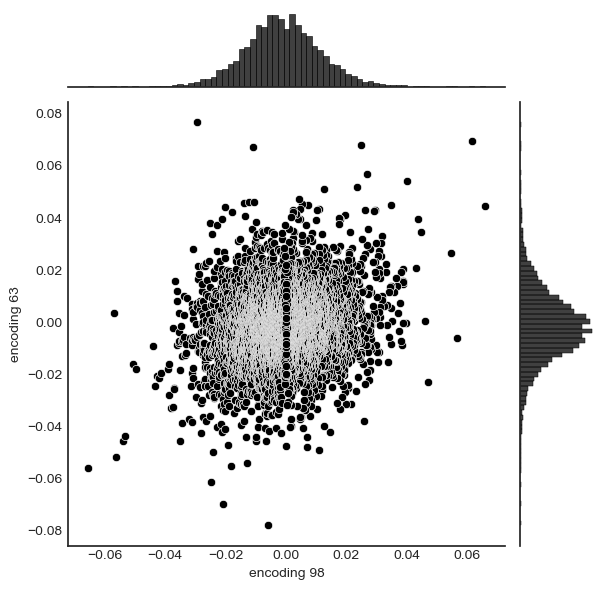

In [17]:
draw_extracted_weights(weight100_layer_df, 98, 63)

        encoding 282  encoding 280
KDM5D      -0.238425     -0.022926
DDX3Y      -0.216454     -0.019467
ZFY        -0.199022     -0.019810
RPS4Y1     -0.185271     -0.017313
NLGN4Y     -0.181307     -0.017108


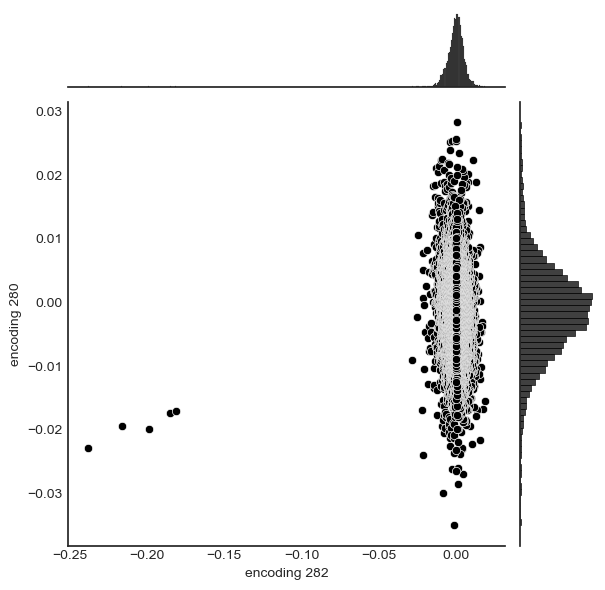

In [18]:
draw_extracted_weights(weight500_layer_df, 282, 280)

        encoding 77  encoding 913
ESR1       0.030794      0.008079
PRR15      0.025958     -0.001399
CDC20B     0.024547     -0.010117
IGDCC3     0.024054      0.001010
KCNK15     0.023845     -0.000984


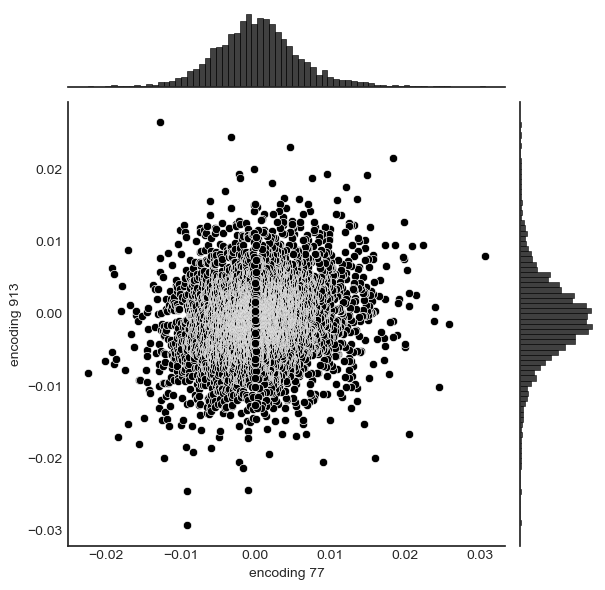

In [19]:
draw_extracted_weights(weight1000_layer_df, 77, 913)